# Рынок заведений общественного питания Москвы

Заказчик решил открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой.Инвесторов интересует текущее положение дел на рынке.  
Требуется подготовить исследование рынка. На руках есть открытые данные о заведениях общественного питания в Москве.

План работы:  
1. [Выгрузка данных и импорт библиотек](#Выгрузка-данных-и-импорт-библиотек)  
1. [Предобработка данных](#Предобработка-данных)   
1. [Анализ данных](#Анализ-данных)  
    1. [Анализ типов заведений](#Анализ-типов-заведений)  
    1. [Анализ расположения заведений](#Анализ-расположения-заведений)  
1. [Вывод](#Вывод)  

# Выгрузка данных и импорт библиотек

In [18]:
# Импортируем необходимые библиотеки и модули
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns 

from io import BytesIO
import requests

In [19]:
# Считаем данные из датасета rest_data и проверим корректность выгрузки
rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


In [20]:
# Расмотрим общую информацию о данных
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В таблице rest_data 6 столбцов. В них содержится информация о рынке общесвтенного питания в Мсокве:  
* **id** - идентификационный номер;
* **object_name** — название объекта общественного питания;
* **chain** — сетевой ли ресторан;
* **object_type** — тип объекта общественного питания;
* **address** — адрес;
* **number** — количество посадочных мест.

В данных нет пропусков. Типы данных верны. В столбце object_name навзания написаны разными регистрами, от этого лучше избавиться.

## Предобработка данных

In [21]:
# Проверим датасет на наличие дубликатов.
rest_data.drop(['id', 'number'], axis=1).duplicated().sum()

170

In [22]:
# Удалим дубликаты, сбросим нумерацию индексов и проверим результат
rest_data = rest_data.drop(rest_data[rest_data.drop(['id', 'number'], axis=1).duplicated()].index ).reset_index(drop = True)
rest_data.duplicated().sum()

0

In [23]:
# Для удобства переименуем колонки
rest_data.columns = ['id', 'place_name', 'chain', 'place_type', 'address', 'number_of_seats']
rest_data.head()

,id,place_name,chain,place_type,address,number_of_seats
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [24]:
# Приведем столбец с названиями к нижнему регистру и проверим резульат
rest_data ['place_name'] = rest_data['place_name'].str.lower()
rest_data.head()

,id,place_name,chain,place_type,address,number_of_seats
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


### Промежуточный вывод  
Мы избавились от дубликатов, переименовали столбцы, и привели содержимое столбца **place_name** к нижнему регистру.

## Анализ данных

### Анализ типов заведений

Исследуем соотношение типов объектов общественного питания по количеству.

In [25]:
# Сгруппируем данные по типу заведений
place_grouped = rest_data.groupby('place_type').agg( count = ('place_type', 'count')).sort_values(by='count', ascending=False)
place_grouped['rate%'] = round(place_grouped['count'] /  place_grouped['count'].sum() *100,2)
place_grouped

,count,rate%
place_type,,
кафе,6017,39.60
столовая,2575,16.95
ресторан,2276,14.98
предприятие быстрого обслуживания,1891,12.44
бар,853,5.61
буфет,571,3.76
кафетерий,393,2.59
закусочная,348,2.29
магазин (отдел кулинарии),272,1.79


In [26]:
# Перед построением графиков установим стиль и палитру
sns.set_style("darkgrid")
sns.set_palette('Paired')

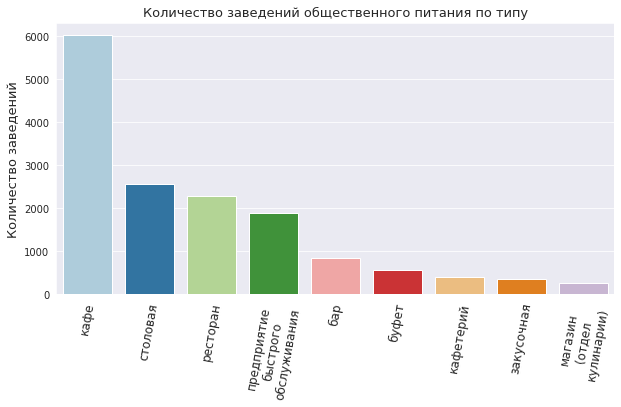

In [27]:
# Построим столбчатую диаграмму. Для удобства вывода немного изменим подписи на графике
lables = list(map(lambda x: x.replace(" ", '\n'), place_grouped.index))

plt.figure(figsize=(10, 5))
sns.barplot(x=lables, y="count", data=place_grouped)
plt.xticks(rotation=80, fontsize = 12 )
plt.title('Количество заведений общественного питания по типу', fontsize = 13)
plt.ylabel('Количество заведений', fontsize = 13);

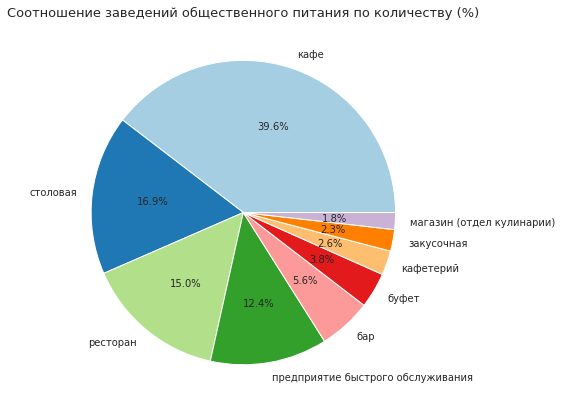

In [28]:
# Построим круговую диаграмму
place_grouped.plot(y='count', kind='pie', figsize=(7,7), autopct='%1.1f%%')
plt.ylabel('')
plt.title('Соотношение заведений общественного питания по количеству (%)', fontsize = 13)
plt.legend().set_visible(False)

### Промежуточный вывод  
С большим отрывом лидируют кафе, далее идут столовые и рестораны. Суммарно они занимают около 70% рынка.

***

Исследуем соотношение сетевых и несетевых заведений по количеству. 

In [29]:
# Сгруппируем данные и посчитаем мтерики
chain_grouped = rest_data.groupby('chain').agg( count = ('chain', 'count'))
chain_grouped['rate%'] = round(chain_grouped['count'] /  chain_grouped['count'].sum() *100,2)
chain_grouped

,count,rate%
chain,,
да,2951,19.42
нет,12245,80.58


Сетевых заведений примерно в четыре раза меньше.

In [30]:
# Посчитаем количество сетевых и несестевых заведений для каждого типа 
place_chain_grouped = (rest_data
               .groupby(['place_type', 'chain'])
               .agg(count = ('place_type', 'count'))
               .reset_index()
               .sort_values(by='count', ascending=False))
place_chain_grouped

,place_type,chain,count
7,кафе,нет,4628
17,столовая,нет,2572
15,ресторан,нет,1734
6,кафе,да,1389
13,предприятие быстрого обслуживания,нет,1107
1,бар,нет,816
12,предприятие быстрого обслуживания,да,784
3,буфет,нет,560
14,ресторан,да,542
9,кафетерий,нет,342


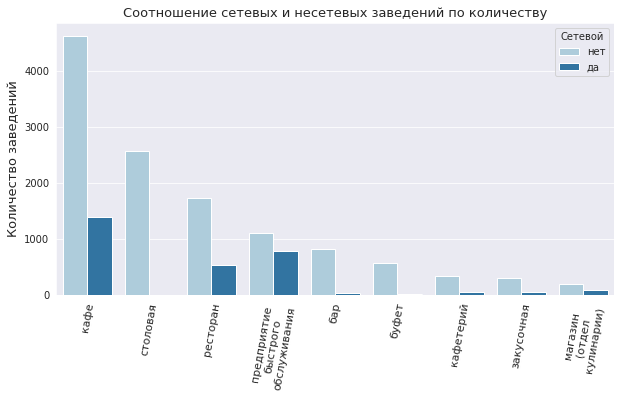

In [31]:
# Построим график по всем заведениям Для удобства вывода немного изменим подписи на графике
lables = list(map(lambda x: x.replace(" ", '\n'), place_chain_grouped['place_type']))

plt.figure(figsize=(10, 5))
sns.barplot(x=lables, y="count", hue='chain', data=place_chain_grouped)
plt.xticks(rotation=80, fontsize = 11 )
plt.title('Соотношение сетевых и несетевых заведений по количеству', fontsize = 13)
plt.ylabel('Количество заведений', fontsize = 13)
plt.legend(title="Сетевой");

Пропорции по количеству для сетевых и несетевых не сохраняются: на графике несетевые плавно убывают слева направо, в то время как сетевые изменяются скачкообразно.

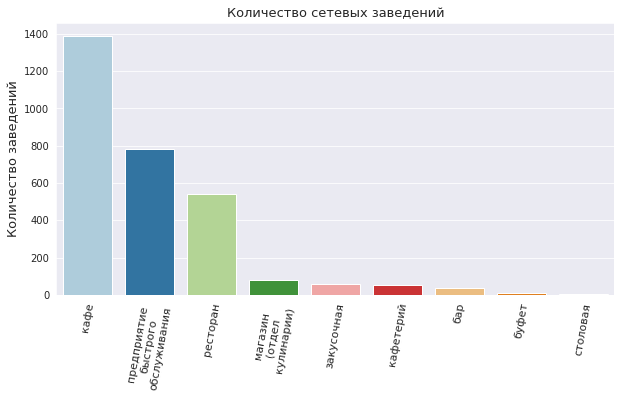

In [32]:
# Построим график только по сетевым заведениям
lables = list(map(lambda x: x.replace(" ", '\n'), place_chain_grouped.query('chain == "да"')['place_type']))

plt.figure(figsize=(10, 5))
sns.barplot(x=lables, y="count" , data=place_chain_grouped.query('chain == "да"'))
plt.xticks(rotation=80, fontsize = 11 )
plt.title('Количество сетевых заведений', fontsize = 13)
plt.ylabel('Количество заведений', fontsize = 13);

In [33]:
# Узнаем процентное соотношение количества сетевых заведений к общему количеству
place_chain = (place_chain_grouped
               .query('chain == "да"')
               .merge(place_grouped
                      .reset_index()[['place_type', 'count']],
                      left_on='place_type', right_on='place_type',
                      suffixes=['', '_all']))

place_chain['rate%'] = round(place_chain['count'] / place_chain['count_all']*100,2)
place_chain.drop(['chain', 'count_all'], axis=1)

,place_type,count,rate%
0,кафе,1389,23.08
1,предприятие быстрого обслуживания,784,41.46
2,ресторан,542,23.81
3,магазин (отдел кулинарии),78,28.68
4,закусочная,56,16.09
5,кафетерий,51,12.98
6,бар,37,4.34
7,буфет,11,1.93
8,столовая,3,0.12


### Промежуточный вывод  
Сетевых заведений в Москве в 4 раза меньше чем несетевых. Среди стевых наиболее распространены кафе, рестораны и предприятия быстрого обслуживания (по сути обычные "забегаловки").

***

Выясним, что более характерно для сетевых заведений:
* **много** заведений с **небольшим** числом посадочных мест в каждом  
или
* **мало** заведений с **большим** количеством посадочных мест

In [34]:
# Выделим сетевые рестораны
chain_places = rest_data.query('chain == "да"')
chain_places.head()

,id,place_name,chain,place_type,address,number_of_seats
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
13,22579,алло пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32
16,144107,суши wok,да,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 3",7
18,58565,тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160


In [35]:
# Сгруппируем сети по названиям, посчитаем кол-во заведений и посадочных мест
chain_places_grouped = (chain_places
                        .groupby('place_name')
                        .agg( place_count = ('place_name', 'count'),
                             median_number=('number_of_seats','median')))
chain_places_grouped.head()

,place_count,median_number
place_name,,
beverly hills diner,1,88.0
bierloga,1,75.0
black & white,1,40.0
bocconcino,3,68.0
boobo,1,46.0


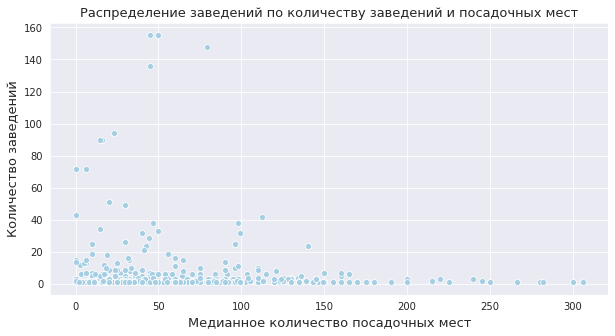

In [36]:
# Построим точечный график зависимости количества заведений и медианнного количества мест
plt.figure(figsize=(10, 5))
sns.scatterplot(x="median_number", y="place_count", data=chain_places_grouped);
plt.title('Распределение заведений по количеству заведений и посадочных мест', fontsize = 13)
plt.ylabel('Количество заведений', fontsize = 13);
plt.xlabel('Медианное количество посадочных мест', fontsize = 13);

### Промежуточный вывод  
Большинство сетей имеет до 20 заведений и в них до 150 мест.

***

Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Узнаем, какой вид предоставляет в среднем самое большое количество посадочных мест.

In [37]:
# Сгруппируем сети по названиям, посчитаем кол-во заведений и посадочных мест
chain_places_grouped = (chain_places
                        .groupby('place_name')
                        .agg( place_count = ('place_name', 'count'),
                             median_number=('number_of_seats','median')))
chain_places_grouped.head()

,place_count,median_number
place_name,,
beverly hills diner,1,88.0
bierloga,1,75.0
black & white,1,40.0
bocconcino,3,68.0
boobo,1,46.0


In [38]:
# Посчитаем среднее количество посадочных мест
place_grouped = (place_grouped
                 .join(rest_data
                       .groupby('place_type')
                       .agg( av_number_of_seats = ('number_of_seats', 'mean'))
                       .round()))
place_grouped

,count,rate%,av_number_of_seats
place_type,,,
кафе,6017,39.60,40.0
столовая,2575,16.95,130.0
ресторан,2276,14.98,97.0
предприятие быстрого обслуживания,1891,12.44,21.0
бар,853,5.61,44.0
буфет,571,3.76,52.0
кафетерий,393,2.59,9.0
закусочная,348,2.29,8.0
магазин (отдел кулинарии),272,1.79,6.0


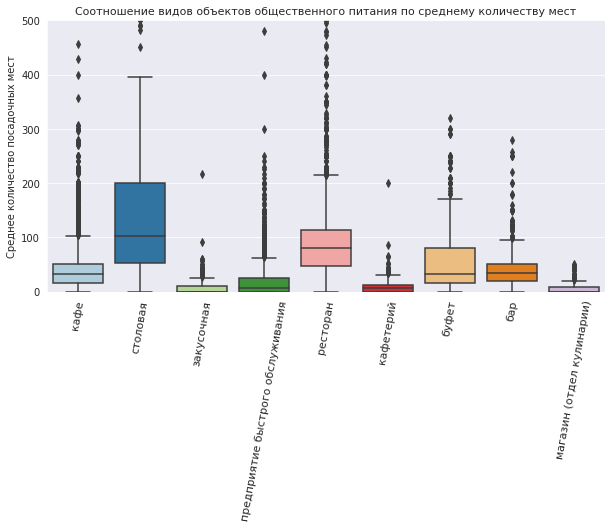

In [39]:
# Исследуем соотношение видов объектов общественного питания по количеству мест
plt.figure(figsize=(10, 5))
plt.ylim(-1, 500)
sns.boxplot(x="place_type", y="number_of_seats", data=rest_data)
plt.xticks(rotation=80, fontsize = 11 )
plt.title('Соотношение видов объектов общественного питания по среднему количеству мест', fontsize = 11)
plt.ylabel('Среднее количество посадочных мест', fontsize = 10);
plt.xlabel('');

### Промежуточный вывод  
Больше всего посадочных мест в столовых и в ресторанах.

### Анализ расположения заведений

Выделим в отдельный столбец информацию об улице из столбца address. Для автоматизации этого процесса возьмем перечень с типами улиц из [Википедии](https://ru.wikipedia.org/wiki/Улица).

In [40]:
# Создадим список со всеми классами улиц
street_list = ['улица', 'бульвар', 'переулок', 'проезд' , 'проспект', 'шоссе',\
               'линия','площадь', 'набережная', 'аллея', 'квартал' ]

In [41]:
# Создадим вспомогатльеную функцию для извлечения улицы из адреса
def get_street(address):
    for subject in address.split(','): # Разобьем адрес на субъекты
        if len(list(set(street_list) & set(subject.split()))): # Разобьем субъект на свлоа и найдем вхождение в street_list
            return subject.strip()  

In [42]:
# Извлечем названия улиц из адресов и проверим результат
rest_data['street'] = rest_data['address'].apply(get_street)
rest_data['street'].head() 

0    улица Егора Абакумова
1         улица Талалихина
2     Абельмановская улица
3       Абрамцевская улица
4       Абрамцевская улица
Name: street, dtype: object

In [43]:
# Проверим, сколько осталось незаполненных ячеек
rest_data['street'].isna().sum()

394

In [44]:
print("Доля незаполненных улиц: {:.2%}".format(rest_data['street'].isna().sum() / rest_data.shape[0]))

Доля незаполненных улиц: 2.59%


In [45]:
# Изучим, из каких адресов не полуичлось извлечь имя улицы
rest_data.query('street.isna()')['address'] 

1402            город Москва, город Зеленоград, корпус 401
1403            город Москва, город Зеленоград, корпус 435
1404            город Москва, город Зеленоград, корпус 436
1405            город Москва, город Зеленоград, корпус 438
1406           город Москва, город Зеленоград, корпус 834А
                               ...                        
14837    город Москва, поселение Десеновское, деревня В...
14850    поселение "Мосрентген", деревня Дудкино, владе...
14972    город Москва, город Зеленоград, Проезд № 4806,...
15018          город Москва, город Зеленоград, корпус 1627
15106    город Москва, микрорайон Северное Чертаново, д...
Name: address, Length: 394, dtype: object

Поверхностный взгляд дает понять, что речь идет о различных специфичных субъектах, где отсутствует классическое деление на улицы: деревни, микрорайоны, город Зеленоград (город полностью без улиц) и тд. Учитывая, что суммарно таких строк менеее 3%, то в дальнейшем исследовании их можно не учитывать.

Необходимо узнать, в каких районах Москвы находятся эти улицы. Для этого воспользуемся внешним источником: [Адресный реестр объектов недвижимости города Москвы](https://data.mos.ru/opendata/60562). Скачаем таблицу и зальем на Google Drive.

In [46]:
# Импортируем данные с гугл драйва
spreadsheet_id = '1M4ImEr1S-xvZb81R4waRK6aveQL49Vefobd030yPM90'

file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
reestr = pd.read_csv(BytesIO(r.content))
reestr.head()

,ADM_AREA,DISTRICT,P3
0,Южный административный округ,муниципальный округ Чертаново Южное,Варшавское шоссе
1,Восточный административный округ,муниципальный округ Вешняки,Косинская улица
2,Центральный административный округ,муниципальный округ Басманный,Гороховский переулок
3,Восточный административный округ,муниципальный округ Метрогородок,Тагильская улица
4,Северный административный округ,муниципальный округ Сокол,Ленинградский проспект


In [47]:
# Оставим только нужные столбцы и переименуем столбцы
reestr = reestr[['P3', 'ADM_AREA', 'DISTRICT']]
reestr.columns = ['street', 'adm_area', 'district']
reestr.head()

,street,adm_area,district
0,Варшавское шоссе,Южный административный округ,муниципальный округ Чертаново Южное
1,Косинская улица,Восточный административный округ,муниципальный округ Вешняки
2,Гороховский переулок,Центральный административный округ,муниципальный округ Басманный
3,Тагильская улица,Восточный административный округ,муниципальный округ Метрогородок
4,Ленинградский проспект,Северный административный округ,муниципальный округ Сокол


In [48]:
# Узнаем общую информацию про данные
reestr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6785 entries, 0 to 6784
Data columns (total 3 columns):
street      6651 non-null object
adm_area    6785 non-null object
district    6785 non-null object
dtypes: object(3)
memory usage: 159.1+ KB


В таблице reestr 4 столбца. В них содержится информация об объектах в Мсокве:  
* **street** — улица объекта;
* **adm_area** — административный округ объекта;
* **district** — район объекта;

В данных есть пропуски с толбце street. Это вызвано тем, что не у всех объектов есть улица в адресе.

In [49]:
# Выделим столбцы с улицей,районом и окргуом, проверим на наличие дубликатов
reestr_cleared = reestr[['street', 'adm_area', 'district']]
reestr_cleared.duplicated().sum()

0

In [50]:
# Объеденим данные
rest_data_merged = (rest_data
                    .query('~street.isna()')
                    .merge(reestr_cleared
                           .query('~street.isna()'),
                           left_on='street', right_on='street'))
rest_data_merged

,id,place_name,chain,place_type,address,number_of_seats,street,adm_area,district
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,Северо-Восточный административный округ,муниципальный округ Ярославский
1,193477,grill-house,нет,закусочная,"город Москва, улица Егора Абакумова, дом 14А",0,улица Егора Абакумова,Северо-Восточный административный округ,муниципальный округ Ярославский
2,196756,пекарня,нет,кафетерий,"город Москва, улица Егора Абакумова, дом 14А",12,улица Егора Абакумова,Северо-Восточный административный округ,муниципальный округ Ярославский
3,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Юго-Западный административный округ,муниципальный округ Южное Бутово
4,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Юго-Восточный административный округ,муниципальный округ Нижегородский
...,...,...,...,...,...,...,...,...,...
33277,223171,кондитерская «пряник.рогалик»,нет,кафе,"город Москва, город Троицк, Пионерская улица, ...",20,Пионерская улица,Новомосковский административный округ,городской округ Щербинка
33278,213851,ресторан «атмосфера»,нет,ресторан,"город Москва, улица Василисы Кожиной, дом 1, к...",49,улица Василисы Кожиной,Западный административный округ,муниципальный округ Филевский Парк
33279,213864,столовая,нет,столовая,"город Москва, улица Василисы Кожиной, дом 1, к...",49,улица Василисы Кожиной,Западный административный округ,муниципальный округ Филевский Парк
33280,213930,горячий хлеб,нет,предприятие быстрого обслуживания,"город Москва, поселение Десеновское, улица Дми...",0,улица Дмитрия Рябинкина,Новомосковский административный округ,внутригородская территория поселение Десеновское


Видим увеличение количества строк почти в два раза, что вызвано повялением дубликатов (строки 3 и 4). Эти дубли появляются из-за того, что одна улица может пересекать несколько районов.

***

Узнаем топ-10 улиц по количеству объектов общественного питания.

In [57]:
# Избавимся от дубликатов
clean_rest_data_merged = rest_data_merged.drop(rest_data_merged[rest_data_merged.drop(['adm_area', 'district'], axis=1).duplicated()].index ).reset_index(drop = True)
clean_rest_data_merged.head()

,id,place_name,chain,place_type,address,number_of_seats,street,adm_area,district
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,Северо-Восточный административный округ,муниципальный округ Ярославский
1,193477,grill-house,нет,закусочная,"город Москва, улица Егора Абакумова, дом 14А",0,улица Егора Абакумова,Северо-Восточный административный округ,муниципальный округ Ярославский
2,196756,пекарня,нет,кафетерий,"город Москва, улица Егора Абакумова, дом 14А",12,улица Егора Абакумова,Северо-Восточный административный округ,муниципальный округ Ярославский
3,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Юго-Западный административный округ,муниципальный округ Южное Бутово
4,83942,кафе даиси,нет,кафе,"город Москва, улица Талалихина, дом 31А/2",78,улица Талалихина,Юго-Западный административный округ,муниципальный округ Южное Бутово


In [58]:
# сгруппируем данные и посчитаем количество заведений
top_10_street = (clean_rest_data_merged
                 .groupby('street')
                 .agg( place_count = ('id', 'count'))
                 .sort_values(by='place_count', ascending=False)
                 .head(10))
top_10_street

,place_count
street,
проспект Мира,197
Профсоюзная улица,181
Ленинградский проспект,172
Пресненская набережная,165
Варшавское шоссе,164
Ленинский проспект,148
проспект Вернадского,127
Кутузовский проспект,114
Каширское шоссе,110


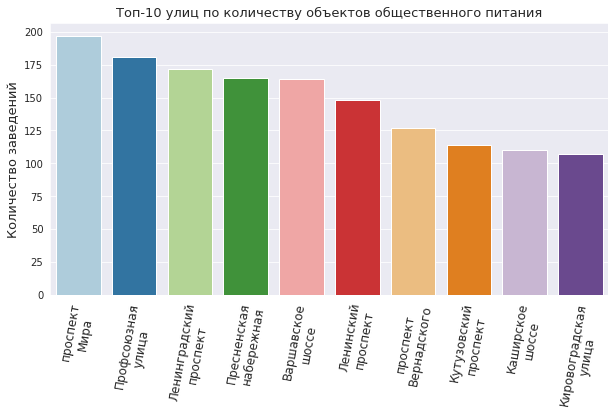

In [59]:
# Построим столбчатую диаграмму. Для удобства вывода немного изменим подписи на графике
lables = list(map(lambda x: x.replace(" ", '\n'), top_10_street.index))

plt.figure(figsize=(10, 5))
sns.barplot(x=lables, y="place_count", data=top_10_street)
plt.xticks(rotation=80, fontsize = 12 )
plt.title('Топ-10 улиц по количеству объектов общественного питания', fontsize = 13)
plt.ylabel('Количество заведений', fontsize = 13);

В топ входят самые длинные улицы, которые проходят через весь город и ведут к центру. В целом логичный результат: чем длинее улица, тем больше объектов на ней помещается.  
Узнаем, в каких районах Москвы находятся эти улицы. 

In [60]:
# Добавим для каждой улицы все районы, которые она пересекает
top_10_street_grouped = (top_10_street
                         .reset_index()
                         .merge(reestr_cleared
                                .query('~street.isna()'),
                                left_on='street', right_on='street')
                         .groupby(['street', 'district', 'adm_area'])
                         .agg( place_count = ('place_count', 'max'))
                         .reset_index())
top_10_street_grouped.head(10)[['street', 'district']]

,street,district
0,Варшавское шоссе,муниципальный округ Донской
1,Варшавское шоссе,муниципальный округ Нагатино-Садовники
2,Варшавское шоссе,муниципальный округ Нагорный
3,Варшавское шоссе,муниципальный округ Северное Бутово
4,Варшавское шоссе,муниципальный округ Чертаново Северное
5,Варшавское шоссе,муниципальный округ Чертаново Центральное
6,Варшавское шоссе,муниципальный округ Чертаново Южное
7,Варшавское шоссе,муниципальный округ Южное Бутово
8,Каширское шоссе,муниципальный округ Москворечье-Сабурово
9,Каширское шоссе,муниципальный округ Нагатино-Садовники


### Промежуточный вывод  
Районов много для каждой улицы, что также логично: длинная улица, пересекающая весь город, также пересекает несколько районов.

***

Найдем число улиц с одним объектом общественного питания, и узнаем в каких районах Москвы находятся эти улицы.

In [173]:
# Выделим те улицы, где всего 1 заведение
lonely_street = rest_data_merged.groupby('street').agg( place_count = ('id', 'count')).query('place_count == 1').reset_index() 
lonely_street

,street,place_count
0,1-й Балтийский переулок,1
1,1-й Ботанический проезд,1
2,1-й Вешняковский проезд,1
3,1-й Голутвинский переулок,1
4,1-й Зачатьевский переулок,1
...,...,...
469,улица Шеногина,1
470,улица Школа-интернат,1
471,улица Шумилова,1
472,улица Шумкина,1


Получаем **474** улицы с одним заведением. Узнаем, в каких районах Москвы находятся эти улицы. 

In [174]:
# Узнаем сколько и в какие районы входят эти улицы
rest_data_merged.query('street.isin(@lonely_street.street)')['district'].value_counts().head(10)

муниципальный округ Таганский         24
муниципальный округ Хамовники         22
муниципальный округ Басманный         20
муниципальный округ Тверской          18
муниципальный округ Пресненский       16
муниципальный округ Марьина Роща      15
муниципальный округ Замоскворечье     12
муниципальный округ Соколиная Гора    11
муниципальный округ Сокольники        11
муниципальный округ Мещанский         11
Name: district, dtype: int64

### Промежуточный вывод  
Если изучить местоположение этих районов на карте, то можно узнать, что эти районы в основном являются спальными и расположены за пределамии кольцевой линии.

***

Изучим распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

In [175]:
# Выделим улицы, где заведений больше 50
big_streets = (rest_data_merged
                  .groupby('street')
                  .agg( place_count = ('id', 'count'))
                  .sort_values(by='place_count', ascending=False)
                  .query('place_count > 50')
                  .index)

big_streets_data = rest_data_merged.query('street.isin(@big_streets)')
big_streets_data.head()

,id,place_name,chain,place_type,address,number_of_seats,street,adm_area,district
175,84832,кафе уют,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Северо-Восточный административный округ,муниципальный округ Алтуфьевский
176,84832,кафе уют,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Северо-Восточный административный округ,муниципальный округ Отрадное
177,84832,кафе уют,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Северо-Восточный административный округ,муниципальный округ Лианозово
178,84832,кафе уют,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Северо-Восточный административный округ,муниципальный округ Бибирево
179,26931,долина чайхона,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",150,Алтуфьевское шоссе,Северо-Восточный административный округ,муниципальный округ Алтуфьевский


In [176]:
# Проверим датасет на наличие дубликатов.
big_streets_data.drop(['adm_area', 'district'], axis=1).duplicated().sum()

15545

In [177]:
# Удалим дубликаты, сбросим нумерацию индексов и проверим результат
big_streets_data = (big_streets_data
                    .drop(big_streets_data[big_streets_data
                                           .drop(['adm_area', 'district'], axis=1)
                                           .duplicated()].index )
                    .reset_index(drop = True))
big_streets_data.duplicated().sum()

0

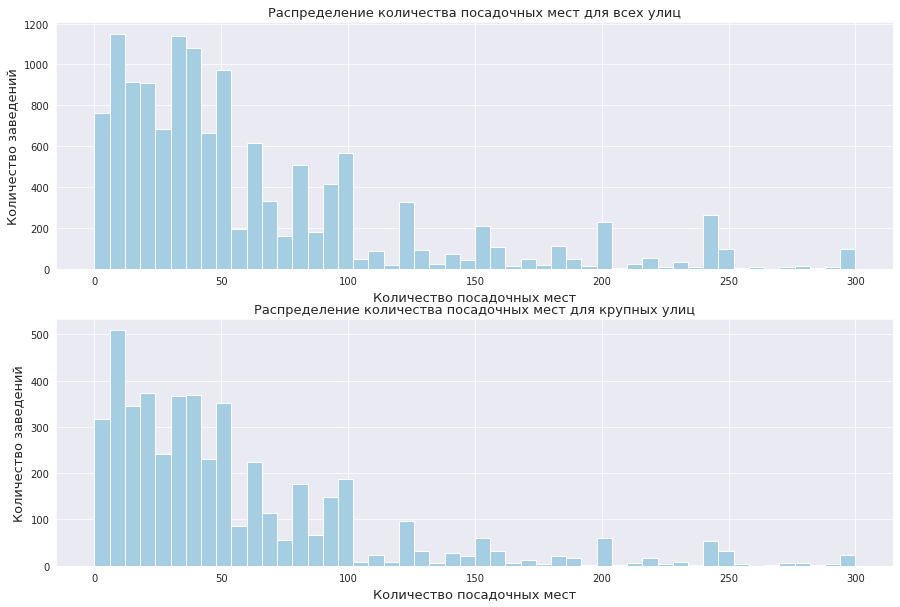

In [178]:
# Построим графики
fig = plt.figure(figsize=(15,10))
ax_1 = fig.add_subplot(211)
ax_2 = fig.add_subplot(212)

ax_1.hist(rest_data.query('number_of_seats !=0')['number_of_seats'],bins=50, range=(0, 300))
ax_1.set_title('Распределение количества посадочных мест для всех улиц', fontsize = 13)
ax_1.set_ylabel('Количество заведений', fontsize = 13)
ax_1.set_xlabel('Количество посадочных мест', fontsize = 13)

ax_2.hist(big_streets_data.query('number_of_seats !=0')['number_of_seats'],bins=50, range=(0, 300))
ax_2.set_title('Распределение количества посадочных мест для крупных улиц', fontsize = 13)
ax_2.set_ylabel('Количество заведений', fontsize = 13)
ax_2.set_xlabel('Количество посадочных мест', fontsize = 13);

In [179]:
# Утчоним количество улиц
print('Суммарное количество улиц:', len(rest_data['street'].value_counts()))
print('Количество улиц, где заведений больше пятидесяти:', len(big_streets))

Суммарное количество улиц: 1893
Количество улиц, где заведений больше пятидесяти: 104


### Промежуточный вывод  
Видим что распределения почти идентичны, хотя крупных улиц в 18 раз меньше. Можно заметить небольшие пики на ровных значениях: 50, 100, 150, 200 и тд.

# Вывод 

В ходе исследования были сделаны следующие выводы относительно Московского рынка общесвтенного питания:
* В Моске больше всего кафе, столовых и ресторанов. Суммарно они занимают около 70% рынка.
* Сетевых заведений в 4 раза меньше чем несетевых.
* Среди стевых наиболее распространены кафе, рестораны и предприятия быстрого обслуживания.
* Большинство сетей имеет до 20 заведений и в них до 150 мест.
* Больше всего посадочных мест в столовых и в ресторанах.
* Улицы с наибольшим количеством заведений обычно являются очень протяженными и пересекают весь город.
* В спальных районах заведений в разы меньше. 

Для дальнейшего развития собственной сети можно применить две стратегии:
1. "Алый океан": выбрать проверенный и самый распространенный вариант. Открыть кафе, Ставить заведения ближе к центру на самых крупных улицах с большим пассажиропотоком.
2. "Голубой океан": выбрать незанятую нишу. Открывать бары в спальных районах, где не хвататет заведений общесвтенного питания и рынок почти свободен.

Учет потенциальных рисков и прибылей для обоих вариантов требует дополнительного исследования.

Ссылка на презентацию отчет: [Рынок заведений общественного питания Москвы](https://drive.google.com/file/d/1Ywc1Aa7ki6ffCCq1w4q2qZg5b8LGWI7j/view?usp=sharing)